# Geometric Discounting Simulations and Plots

## Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
here = os.getcwd()
sys.path.append(os.path.join(here, '..')) # needed to run from subfolder

from security_games.clinch import clinch, round_clinch_result, BatchedClinchThenCommit
from security_games.utils import SSG, RepeatedSSG, Polytope, gen_non_myopic_with_bounded_lookahead_oracle, RepeatedSSGAlg
from security_games.multi_threaded_clinch import MultiThreadedClinch

In [2]:
def gen_simplex_SSG(n_targets: int, v_low: float, v_high: float) -> SSG:
    dimension = n_targets
    simplex_A = np.concatenate([-np.eye(dimension), np.ones((1, dimension))])
    simplex_b = np.concatenate([np.zeros((dimension, 1)), np.ones((1, 1))])
    simplex = Polytope(simplex_A, simplex_b)

    # values = [np.random.uniform(0.9995, 1) for _ in range(n_targets)]
    values_1 = [np.random.uniform(low=v_low, high=v_high) for _ in range(n_targets)]
    values_2 = [np.random.uniform(low=v_low, high=v_high) for _ in range(n_targets)]

    return SSG(
        n_targets,
        simplex,
        np.array([[0.0, value] for value in values_1]).T,
        np.array([[value, 0.0] for value in values_2]).T,
    )

In [3]:
def find_best_batch_size(game: RepeatedSSG,
                         minimum_width: float,
                         time_horizon: int,
                         get_response: RepeatedSSGAlg.FollowerResponseOracle,
                         min_size: int,
                         max_size: int,
                         num_divisions: int,
                         branching_factor: int): # explore top branching_factor # divisions
    test_sizes = np.arange(min_size, max_size+1, np.maximum((max_size - min_size)//num_divisions,1))
    utilities = np.zeros(len(test_sizes))
    utilities_by_size = {}
    for (i,size) in enumerate(test_sizes):
        res = BatchedClinchThenCommit(game,
                                      minimum_width=minimum_width,
                                      time_horizon=time_horizon,
                                      is_simplex=True,
                                      get_response=get_response,
                                      batch_size=size,
                                      verbose=False).run()
        utilities[i] = utilities_by_size[size] = res.game.leader_utility

    top_size_indices = utilities.argsort()[-branching_factor:][::-1]
    if len(test_sizes) == max_size - min_size + 1: # all sizes tested
        i_star = top_size_indices[0]
        return (test_sizes[i_star], utilities[i_star])
    else:
        top_size_indices = sorted(top_size_indices) # sort the indices so that we scan in order
    
    for i in top_size_indices:
        if i-1 not in top_size_indices and i > 0: # should test interval before
            (B_l, u_l) = find_best_clinch_batch_size(game,
                                                     minimum_width,
                                                     time_horizon,
                                                     get_response, 
                                                     test_sizes[i-1]+1,
                                                     test_sizes[i]-1,
                                                     num_divisions,
                                                     branching_factor)
            utilities_by_size[B_l] = u_l
        if i < len(test_sizes) - 1:
            (B_r, u_r) = find_best_clinch_batch_size(game,
                                                     minimum_width,
                                                     time_horizon,
                                                     get_response, 
                                                     test_sizes[i]+1,
                                                     test_sizes[i+1]-1,
                                                     num_divisions,
                                                     branching_factor)
            utilities_by_size[B_r] = u_r
            
    max_utility = 0
    best_size = 0
    for size in utilities_by_size.keys():
        if utilities_by_size[size] > max_utility:
            max_utility = utilities_by_size[size]
            best_size = size

    assert best_size > 0
    return (best_size, max_utility)       

In [4]:
np.random.seed(1234)

# params for generating SSGs and benchmark solutions
n_games = 5
n_targets = 3
v_low = 0.25
v_high = 0.75
W = v_low / (v_low + (n_targets - 1)*v_high)
benchmark_precision = 1e-4

In [5]:
ssgs = []
benchmark_solutions = []
benchmark_payoffs = []
null_payoffs = []
games = []

for i in range(n_games):
    ssg = gen_simplex_SSG(n_targets=n_targets, v_low=v_low, v_high=v_high)
    ssgs.append(ssg)

    game = RepeatedSSG(ssg, 0.5, discounting_type="geometric")
    # choice of discount factor insubstantial, not used below and will be overwritten
    games.append(game)

    get_response = lambda x,_: ssg.get_best_response(x)
    sol = BatchedClinchThenCommit(game, 
                                  minimum_width=W, 
                                  time_horizon=1000, # increase if search result not found
                                  is_simplex=True,
                                  get_response=get_response,
                                  batch_size=1,
                                  myopic=True,
                                  search_accuracy=benchmark_precision).run().search_result

    benchmark_solutions.append(sol)
    benchmark = ssg.get_leader_payoff(sol)
    benchmark_payoffs.append(benchmark)

    null_payoffs.append(ssg.get_leader_payoff(np.ones(n_targets)/n_targets))

In [6]:
agent_lookahead = 1 # only one non-myopic lookahead step needed for interesting behavior
agent_cutoff = 999999 # controls how far simulations are run into the future, could be cut down to improve performance
get_response = gen_non_myopic_with_bounded_lookahead_oracle(agent_lookahead, agent_cutoff)

In [8]:
T = 500 # time horizon

In [9]:
# code to identify best batch sizes, currently loading saved list of sizes so not needed

# discount_factors = [0.5, 0.75, 0.85]
# B_star_table = {}

# # find the best batch sizes at time horizon T for each discount factor
# for i in range(n_games):
#     for gamma in discount_factors:
#         (B_star, _) = find_best_batch_size(games[i].reset(discount_factor=gamma),W,T,get_response,1,20,5,2)
#         print(f'game:{i}, gamma:{gamma}, B_star:{B_star}')
#         B_star_table[(i,gamma)] = B_star

# # use these to produces an informative set of batch sizes for each plot
# batch_sizes_by_game = {}
# for i in range(n_games):
#     B1 = B_star_table[(i,0.5)]
#     B2 = B_star_table[(i,0.75)]
#     B4 = B_star_table[(i,0.85)]
#     B3 = B2 + (B4 - B2)//2
#     B5 = 2*B4 - B3
#     batch_sizes_by_game[i] = [B1,B2,B3,B4,B5]
#     print((i,batch_sizes_by_game[i]))

# np.save(f'geometric_T{T}_batch-sizes', batch_sizes_by_game)

In [28]:
batch_sizes_by_game = np.load(f'geometric_T{T}_batch-sizes.npy', allow_pickle=True).tolist()

In [30]:
time_horizons = np.arange(20, 501, 20)
discount_factors = [0.5, 0.75, 0.85]

# multi-threaded utilities
mt_utilities = {} # indexed by (game #, gamma, T) tuples
# single-threaded utilities
st_utilities = {} # indexed by (game #, gamma, T, batch_size) tuples

verbose = False

for i in range(n_games):
    print(f'game:{i}')
    print(f'null payoff:{null_payoffs[i]}')
    batch_sizes = batch_sizes_by_game[i]
    for gamma in discount_factors:
        print(f'gamma:{gamma}')
        for T in time_horizons:
            print(f'T:{T}')
            res = MultiThreadedClinch(games[i].reset(discount_factor=gamma),
                                      minimum_width=W,
                                      time_horizon=T,
                                      is_simplex=True,
                                      get_response=get_response,
                                      verbose=False).run()
            mt_utilities[(i,gamma,T)] = res.game.leader_utility
            completed_threads = [2**(j+1) for j in range(len(res.threads)) if res.threads[j].search_result is not None]
            if verbose:
                if res.highest_completed_thread >= 0:
                    best_result = res.threads[res.highest_completed_thread].search_result
                    best_result_payoff = benchmark_payoffs[i] - ssgs[i].get_leader_payoff(best_result)
                else:
                    best_result_payoff = "n/a"
                print(f'MT-U:{res.game.leader_utility}, completed thread delays: {completed_threads}, result payoff: {best_result_payoff}')
    
            for batch_size in batch_sizes:
                res = BatchedClinchThenCommit(games[i].reset(discount_factor=gamma),
                                              minimum_width=W,
                                              time_horizon=T,
                                              is_simplex=True,
                                              get_response=get_response,
                                              batch_size=batch_size,
                                              verbose=False).run()
                st_utilities[(i,gamma,T,batch_size)] = res.game.leader_utility
                if verbose:
                    if res.search_result is None:
                        result_payoff = "n/a"
                    else:
                        result_payoff = benchmark_payoffs[i] - ssgs[i].get_leader_payoff(res.search_result)
                    print(f'B{batch_size}-U:{res.game.leader_utility}, search {"in progress" if res.search_result is None else "complete"}, result payoff: {result_payoff}')

game:0
null payoff:0.11525324172981538
gamma:0.5
T:20
T:40
T:60
T:80
T:100
T:120
T:140
T:160
T:180
T:200
T:220
T:240
T:260
T:280
T:300
T:320
T:340
T:360
T:380
T:400
T:420
T:440
T:460
T:480
T:500
gamma:0.75
T:20
T:40
T:60
T:80
T:100
T:120
T:140
T:160
T:180
T:200
T:220
T:240
T:260
T:280
T:300
T:320
T:340
T:360
T:380
T:400
T:420
T:440
T:460
T:480
T:500
gamma:0.85
T:20
T:40
T:60
T:80
T:100
T:120
T:140
T:160
T:180
T:200
T:220
T:240
T:260
T:280
T:300
T:320
T:340
T:360
T:380
T:400
T:420
T:440
T:460
T:480
T:500
game:1
null payoff:0.12941070919051612
gamma:0.5
T:20
T:40
T:60
T:80
T:100
T:120
T:140
T:160
T:180
T:200
T:220
T:240
T:260
T:280
T:300
T:320
T:340
T:360
T:380
T:400
T:420
T:440
T:460
T:480
T:500
gamma:0.75
T:20
T:40
T:60
T:80
T:100
T:120
T:140
T:160
T:180
T:200
T:220
T:240
T:260
T:280
T:300
T:320
T:340
T:360
T:380
T:400
T:420
T:440
T:460
T:480
T:500
gamma:0.85
T:20
T:40
T:60
T:80
T:100
T:120
T:140
T:160
T:180
T:200
T:220
T:240
T:260
T:280
T:300
T:320
T:340
T:360
T:380
T:400
T:420
T:440


In [31]:
mt_regret = {} # indexed by (game #, gamma, T) tuples
st_regret = {} # indexed by (game #, gamma, T, batch_size) tuples

for i in range(n_games):
    benchmark = benchmark_payoffs[i]
    for gamma in discount_factors:
        for T in time_horizons:
            mt_regret[(i,gamma,T)] = T*benchmark - mt_utilities[(i,gamma,T)]
            for batch_size in batch_sizes_by_game[i]:
                st_regret[(i,gamma,T,batch_size)] = T*benchmark - st_utilities[(i,gamma,T,batch_size)]

In [103]:
#np.save('geometric_T500_B-automated.npy', (mt_regret, st_regret))
#np.load('geometric_T500_B-automated.npy', (mt_regret, st_regret))

## Plots (Figure EC.1 in EC.4.3, UPDATES TO ALSO INCLUDE SECTION 4 SOLO PLOT)

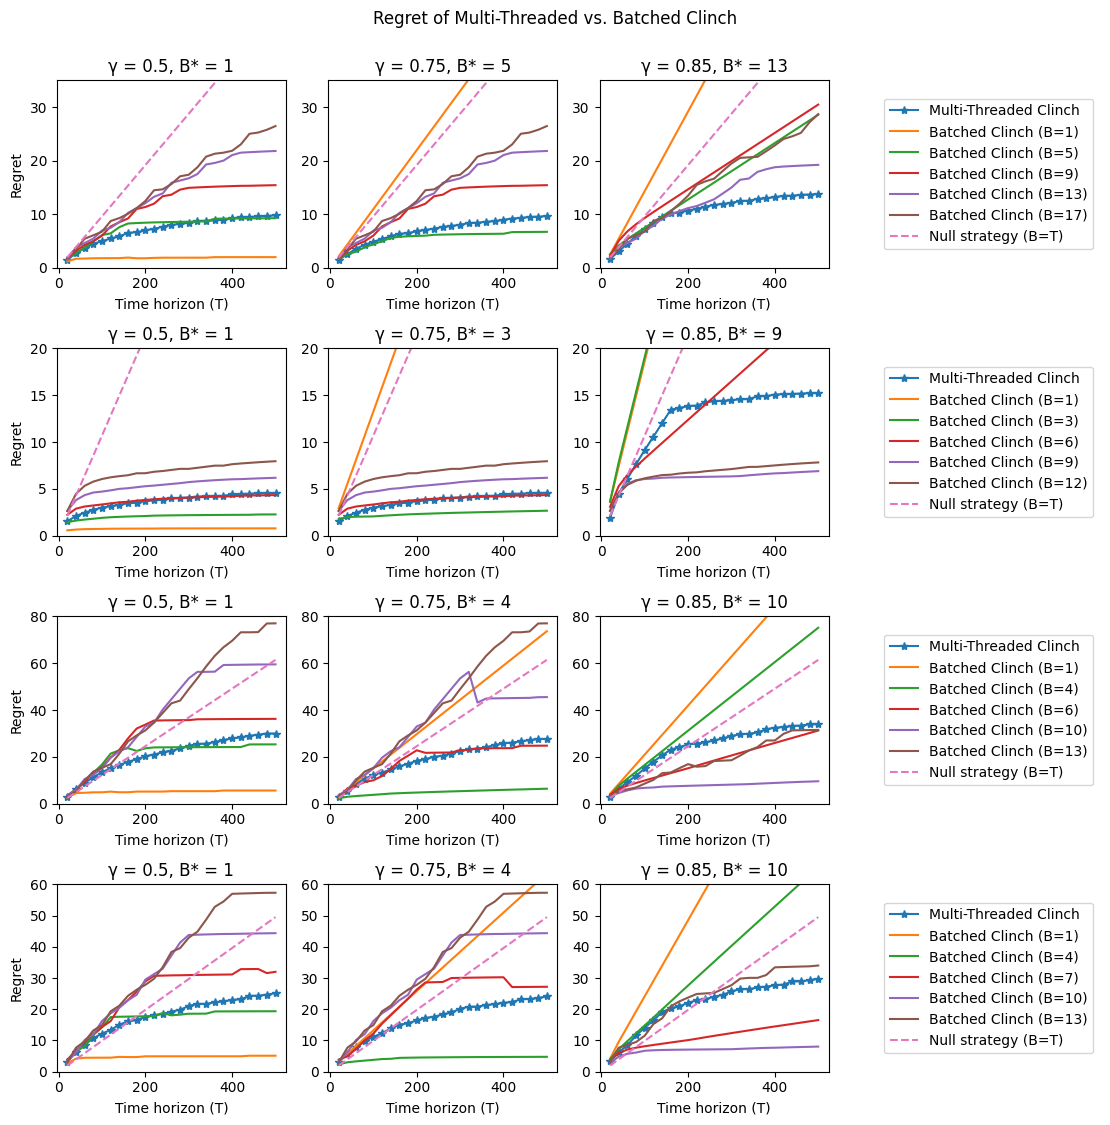

In [60]:
y_lim_list = [70, 35, 20, 80, 60]

fig, axes = plt.subplots(len(games)-1,len(discount_factors)+1, figsize=(14/1.25,(len(games)-1)*3.5/1.25))

for i in range(1,len(games)):
    B_star_by_discount_factor = {
        0.5: batch_sizes_by_game[i][0],
        0.75: batch_sizes_by_game[i][1],
        0.85: batch_sizes_by_game[i][3],
    }
    
    for (j,gamma) in enumerate(discount_factors): 
        x = time_horizons
        y_mt = [mt_regret[(i,gamma,T)] for T in time_horizons]
        y_null = [T*benchmark_payoffs[i] - T*ssgs[i].get_leader_payoff(np.ones(n_targets)/n_targets) for T in time_horizons]
        y_st_table = {}
    
        batch_sizes = sorted(list(set([key[3] for key in st_regret.keys() if key[1] == gamma])))
        for batch_size in batch_sizes_by_game[i]:
            y_st_table[batch_size] = [st_regret[(i,gamma,T,batch_size)] for T in time_horizons]
        
        axes[i-1][j].plot(x,y_mt,"-*",label="Multi-Threaded Clinch")
        
        for (k,batch_size) in enumerate(batch_sizes_by_game[i]):
            axes[i-1][j].plot(x,y_st_table[batch_size],label=f"Batched Clinch (B={batch_size})")
        axes[i-1][j].plot(x,y_null,"--",label="Null strategy (B=T)")
        axes[i-1][j].set_xlabel("Time horizon (T)")
        if j == 0:
            axes[i-1][j].set_ylabel("Regret")
        axes[i-1][j].set_ylim([0,y_lim_list[i]])
        axes[i-1][j].set_title(f"γ = {gamma}, B* = {B_star_by_discount_factor[gamma]}")
        if j == 0:
            handles, labels = axes[i-1][j].get_legend_handles_labels()
    
    axes[i-1][-1].set_axis_off()
    axes[i-1][-1].legend(handles, labels, loc='right')

plt.suptitle('Regret of Multi-Threaded vs. Batched Clinch', y=1)
plt.tight_layout()

In [ ]:
y_lim_list = [70, 35, 20, 80, 60]

fig, axes = plt.subplots(len(games)-1,len(discount_factors)+1, figsize=(14/1.25,(len(games)-1)*3.5/1.25))

for i in range(1,len(games)):
    B_star_by_discount_factor = {
        0.5: batch_sizes_by_game[i][0],
        0.75: batch_sizes_by_game[i][1],
        0.85: batch_sizes_by_game[i][3],
    }
    
    for (j,gamma) in enumerate(discount_factors): 
        x = time_horizons
        y_mt = [mt_regret[(i,gamma,T)] for T in time_horizons]
        y_null = [T*benchmark_payoffs[i] - T*ssgs[i].get_leader_payoff(np.ones(n_targets)/n_targets) for T in time_horizons]
        y_st_table = {}
    
        batch_sizes = sorted(list(set([key[3] for key in st_regret.keys() if key[1] == gamma])))
        for batch_size in batch_sizes_by_game[i]:
            y_st_table[batch_size] = [st_regret[(i,gamma,T,batch_size)] for T in time_horizons]
        
        axes[i-1][j].plot(x,y_mt,"-*",label="Multi-Threaded Clinch")
        
        for (k,batch_size) in enumerate(batch_sizes_by_game[i]):
            axes[i-1][j].plot(x,y_st_table[batch_size],label=f"Batched Clinch (B={batch_size})")
        axes[i-1][j].plot(x,y_null,"--",label="Null strategy (B=T)")
        axes[i-1][j].set_xlabel("Time horizon (T)")
        if j == 0:
            axes[i-1][j].set_ylabel("Regret")
        axes[i-1][j].set_ylim([0,y_lim_list[i]])
        axes[i-1][j].set_title(f"γ = {gamma}, B* = {B_star_by_discount_factor[gamma]}")
        if j == 0:
            handles, labels = axes[i-1][j].get_legend_handles_labels()
    
    axes[i-1][-1].set_axis_off()
    axes[i-1][-1].legend(handles, labels, loc='right')

plt.suptitle('Regret of Multi-Threaded vs. Batched Clinch', y=1)
plt.tight_layout()

In [61]:
#fig.savefig('multi-threaded-geometric-extra-plots.pdf')